<a href="https://colab.research.google.com/github/ankitgupta47/physics_informed_NN/blob/main/PhysicInformedNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [70]:
# Constant for the model
k = 1
F = lambda t, s: -k*s
initial_value = 2.0

In [71]:
class NeuralNet(nn.Module):
    def __init__(self, hidden_size, output_size=1,input_size=1):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.LeakyReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.LeakyReLU()
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.LeakyReLU()
        self.l4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.LeakyReLU()
        self.l5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.l3(out)
        out = self.relu3(out)
        out = self.l4(out)
        out = self.relu4(out)
        out = self.l5(out)
        return out

In [72]:
# Create the criterion that will be used for the DE part of the loss
criterion = nn.MSELoss()

# Define the loss function for the initial condition
def initial_condition_loss(y, target_value):
    return criterion(y, target_value)

In [73]:
# Time vector that will be used as input of our NN
t_numpy = np.arange(0, 5+0.01, 0.01, dtype=np.float32)
t = torch.from_numpy(t_numpy).reshape(len(t_numpy), 1)
t.requires_grad_(True)

# Instantiate one model with 20 neurons on the hidden layers
model = NeuralNet(hidden_size=20)

# Loss and optimizer
learning_rate = 8e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Number of epochs
num_epochs = int(1e4)

In [74]:
for epoch in range(num_epochs):

    # Randomly perturbing the training points to have a wider range of times
    epsilon = torch.normal(0,0.1, size=(len(t),1)).float()
    t_train = t + epsilon

    # Forward pass
    y_pred = model(t_train)

    # Calculate the derivative of the forward pass w.r.t. the input (t)
    dy_dt = torch.autograd.grad(y_pred,
                                t_train,
                                grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]

    # Define the differential equation and calculate the loss
    loss_DE = criterion(dy_dt + k*y_pred, torch.zeros_like(dy_dt))

    # Define the initial condition loss
    loss_IC = initial_condition_loss(model(torch.tensor([[0.0]])),
                                     torch.tensor([[initial_value]]))

    loss = loss_DE + loss_IC

    # Backward pass and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

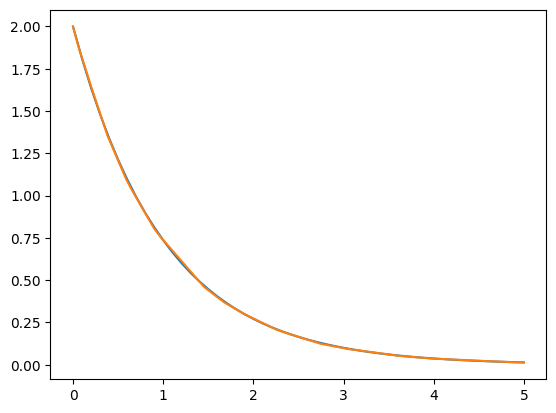

In [75]:
# comparing Ode solution and physics informed neural network

t_final = 5.0
t_eval = np.arange(0,t_final+0.1, 0.1)
sol = solve_ivp(F, [0, t_final], [initial_value], t_eval=t_eval)
plt.plot(sol.t, sol.y[0])

model.eval()
t_numpy = np.arange(0, 5+0.01, 0.01, dtype=np.float32)
t_p = torch.from_numpy(t_numpy).reshape(len(t_numpy), 1)
y_model = model(t_p)
y_model = y_model.detach().numpy()
plt.plot(t_numpy, y_model)
